In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

c:\Users\thoma\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
def computeLocalPUDensity(all_events_vertex_xs, delta_x):
    localPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        localPUdensity.append((np.sum(np.abs(vertex_xs[0]-vertex_xs[1:]) < delta_x))/(2*delta_x))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_xs, mu=200, sigma_x=50):
    avgPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        avgPUdensity.append(mu/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_xs[0]**2/sigma_x**2))
    return avgPUdensity

In [70]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(3, 12)]
track_z0_var = np.array([], dtype='object') 
track_t = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

# reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')
track_qOverP = np.array([], dtype='object') 
track_theta = np.array([], dtype='object')
for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            # reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))
            
            track_qOverP = np.concatenate((track_qOverP, tree['track_qOverP'].array(library='np')))
            track_theta = np.concatenate((track_theta, tree['track_theta'].array(library='np')))

track_pT = np.abs(np.array([np.sin(theta) for theta in track_theta], dtype='object')/track_qOverP)

In [4]:
## Find truth link via number of shared tracks
recoHS_to_truth_link_idx = []
truthHS_to_reco_link_idx = []
for event_idx in range(len(truth_vertex_t)):
    event_reco_to_truth_n_tracks = -1
    event_reco_to_truth_idx = -1
    reco_hs_track_idx = reco_vertex_track_idxs[event_idx][0]
    for i, truth_track_idxs in enumerate(truth_vertex_track_idxs[event_idx]):
        if i < 100:
            n = len(np.intersect1d(reco_hs_track_idx, truth_track_idxs))
            if n > event_reco_to_truth_n_tracks:
                # print(event_idx, n)
                event_reco_to_truth_n_tracks = n
                event_reco_to_truth_idx = i
    
    event_truth_to_reco_n_tracks = -1
    event_truth_to_reco_idx = -1
    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        if i < 100:
            n = len(np.intersect1d(truth_hs_track_idx, reco_track_idxs))
            if n > event_truth_to_reco_n_tracks:
                # print(event_idx, n)
                event_truth_to_reco_n_tracks = n
                event_truth_to_reco_idx = i
    
    recoHS_to_truth_link_idx.append(event_reco_to_truth_idx)
    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
recoHS_to_truth_link_idx = np.array(recoHS_to_truth_link_idx)
truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)

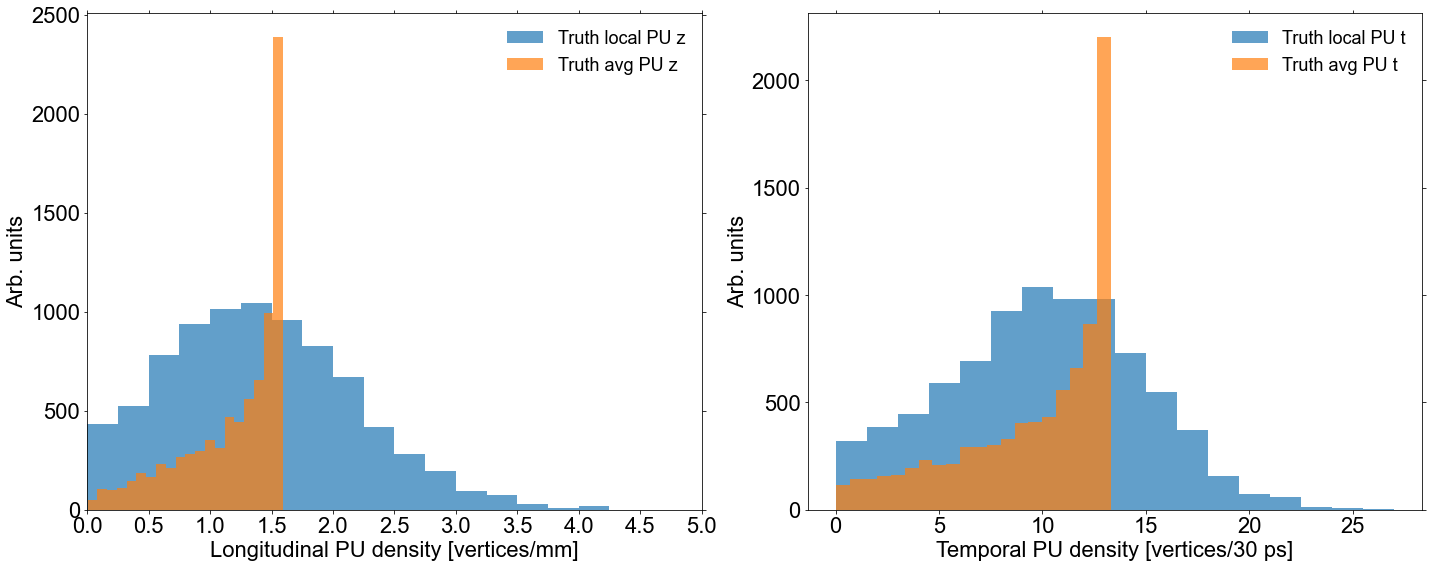

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

delta_z = 2
truth_localzPU = computeLocalPUDensity(truth_vertex_z, delta_z)
truth_avgzPU = computeAvgPUDensity(truth_vertex_z, mu=200, sigma_x=50)


zbinwidth = 1/(2*delta_z)
_, zLPU_truth_bin_edges, _ = ax1.hist(truth_localzPU, bins=np.arange(np.min(truth_localzPU), np.max(truth_localzPU) + zbinwidth, zbinwidth), density=False, alpha=0.7, label='Truth local PU z')
_, zAPU_truth_bin_edges, _ = ax1.hist(truth_avgzPU, bins=20, density=False, alpha=0.7, label='Truth avg PU z')

ax1.set_xlabel('Longitudinal PU density [vertices/mm]')
ax1.set_ylabel('Arb. units')
# ax1.set_yscale('log')
ax1.set_xticks(np.arange(0, 10, 0.5))
ax1.set_xlim(0, 5)
ax1.legend(frameon=False)


sigma_t = 180
delta_t = 20

tPU_unit = 30
truth_localtPU = computeLocalPUDensity(1e3*truth_vertex_t/tPU_unit, delta_t/tPU_unit)
truth_avgtPU = computeAvgPUDensity(1e3*truth_vertex_t/tPU_unit, mu=200, sigma_x=sigma_t/tPU_unit)

tbinwidth = 1/(2*delta_t/tPU_unit) * 2
_, tLPU_truth_bin_edges, _ = ax2.hist(truth_localtPU, bins=np.arange(np.min(truth_localtPU), np.max(truth_localtPU) + tbinwidth, tbinwidth), density=False, alpha=0.7, label='Truth local PU t', color='C0')
_, tAPU_truth_bin_edges, _ = ax2.hist(truth_avgtPU, bins=20, density=False, alpha=0.7, label='Truth avg PU t', color='C1')

ax2.set_xlabel('Temporal PU density [vertices/{} ps]'.format(tPU_unit))
ax2.set_ylabel('Arb. units')
# ax2.set_yscale('log')
# ax2.set_xticks(np.arange(0, 0.5, 0.1))
# ax2.set_xlim(0, 0.5)
ax2.legend(frameon=False)
fig.tight_layout()

In [6]:
events_in_zLPU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_zLPU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))
events_in_tLPU_bins = []
for bin in tLPU_truth_bin_edges:
    events_in_tLPU_bins.append(np.argwhere(np.isclose(truth_localtPU, bin)))

events_in_zAPU_bins = []
for i, bin in enumerate(zAPU_truth_bin_edges[1:]):
    events_in_zAPU_bins.append(np.argwhere(np.logical_and(truth_avgzPU > zAPU_truth_bin_edges[i-1], truth_avgzPU < bin)))
events_in_tAPU_bins = []
for i, bin in enumerate(tAPU_truth_bin_edges[1:]):
    events_in_tAPU_bins.append(np.argwhere(np.logical_and(truth_avgtPU > tAPU_truth_bin_edges[i-1], truth_avgtPU < bin)))

In [111]:
def bootstrap_rms_std(x, n=1000):
    bootstrap_x_rms = []
    for _ in range(n):
        x_idx = np.random.randint(0, len(x), len(x))
        bootstrap_x_rms.append(np.sqrt(np.mean(np.array(x)[x_idx]**2)))
    return np.std(bootstrap_x_rms, ddof=1)

def vtx_time_info(events_in_bins, truth_vtx_idx_in_bins, all_truth_vtx_t, reco_vtx_idx_in_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut, weight_cut, pT_cut):
    ## Track delta ts
    track_delta_t = []
    track_delta_t_rms = []
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    track_sigma_cut_delta_t = []
    track_sigma_cut_delta_t_rms = []
    track_4highest_pT_delta_t = []
    track_4highest_pT_delta_t_rms = []
    
    ## Track based vtx resolution
    track_vtx_t_res = []
    track_vtx_t_res_std = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_std_weight_cut = []
    track_vtx_t_res_sigma_cut = []
    track_vtx_t_res_std_sigma_cut = []
    track_vtx_4highest_pT_t_res = []
    track_vtx_4highest_pT_t_res_std = []

    ## Vertex estimator delta ts
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    vtx_sigma_cut_weighted_delta_t = []
    
    vtx_pT_cut_delta_t = []
    vtx_4highest_pT_delta_t = []
    vtx_4highest_pT_weight_cut_delta_t = []
    vtx_4highest_weight_delta_t = []

    ## Vertex t estimator based vtx resolution 
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []
    vtx_t_res_tracks_sigma_cut = []
    vtx_weighted_t_res_tracks_sigma_cut = []

    vtx_pT_cut_t_res = []
    vtx_4highest_pT_weight_cut_t_res = []
    vtx_4highest_weight_t_res = []
    vtx_4highest_pT_t_res = []
    vtx_4highest_pT_t_res_sigma_cut = []

    ## Vertex t estimator based vtx resolution std deviation
    vtx_t_res_std = []
    vtx_weighted_t_res_std = []
    vtx_weight_cut_t_res_std = []
    vtx_weight_cut_weighted_t_res_std = []
    vtx_sigma_cut_weighted_t_res_std = []
    vtx_t_res_std_tracks_sigma_cut = []
    vtx_weighted_t_res_std_tracks_sigma_cut = []

    vtx_pT_cut_t_res_std = []
    vtx_4highest_pT_weight_cut_t_res_std = []
    vtx_4highest_weight_t_res_std = []
    vtx_4highest_pT_t_res_std = []
    vtx_4highest_pT_t_res_std_sigma_cut = []


    ## Avg reco vertex track multiplicity 
    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_bins, truth_vtx_idx_in_bins, reco_vtx_idx_in_bins):
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_track_4highest_pT_delta_t = np.array([])
        bin_track_4highest_pT_delta_t_rms = []

        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_vtx_pT_cut_delta_t = []
        bin_vtx_4highest_pT_delta_t = []
        bin_vtx_4highest_pT_weight_cut_delta_t = []
        bin_vtx_4highest_weight_delta_t = []

        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[reco_track_clean_idx]
            # reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_t_var = all_track_t_var[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_clean_idx]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_clean_idx] 
            reco_track_pT = all_track_pT[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_clean_idx]

            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights/reco_track_t_var)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            if np.sum(weight_cut_idx) > 0:
                weight_cut_track_t = reco_track_t[weight_cut_idx]
                bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
                
                weight_cut_event_delta_t = weight_cut_track_t - truth_t
            
                bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
                bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
                
                weight_cut_vtx_t = np.mean(weight_cut_track_t)
                weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx]/reco_track_t_var[weight_cut_idx])
                
                bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
                bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
                
                ## Weight cut highest pT vtx t estimator
                if np.sum(weight_cut_idx) >= 4: 
                    weight_cut_highest_pT_track_idx = np.argpartition(reco_track_pT[weight_cut_idx], -4)[-4:]
                    bin_vtx_4highest_pT_weight_cut_delta_t.append(np.average(reco_track_t[weight_cut_highest_pT_track_idx],\
                                weights=reco_track_weights[weight_cut_highest_pT_track_idx]/reco_track_t_var[weight_cut_highest_pT_track_idx]) - truth_t)
            
            ## pT cut vtx t estimators
            pT_cut_idx = reco_track_pT > pT_cut
            if np.sum(pT_cut_idx) > 0:
                reco_vtx_t_pT_cut = np.average(reco_track_t[pT_cut_idx], weights=reco_track_weights[pT_cut_idx]/reco_track_t_var[pT_cut_idx])
                bin_vtx_pT_cut_delta_t.append(reco_vtx_t_pT_cut - truth_t)

            if len(reco_track_t) >= 4:
                highest_pT_track_idx = np.argpartition(reco_track_pT, -4)[-4:]
                bin_vtx_4highest_pT_delta_t.append(np.average(reco_track_t[highest_pT_track_idx],\
                    weights=reco_track_weights[highest_pT_track_idx]/reco_track_t_var[highest_pT_track_idx]) - truth_t)

                bin_track_4highest_pT_delta_t = np.concatenate((bin_track_4highest_pT_delta_t, reco_track_t[highest_pT_track_idx] - truth_t))
                bin_track_4highest_pT_delta_t_rms.append(np.sqrt(np.mean((reco_track_t[highest_pT_track_idx] - truth_t)**2)))

                ## Highest weight vtx t estimator
                highest_weight_track_idx = np.argpartition(reco_track_weights, -4)[-4:]
                bin_vtx_4highest_weight_delta_t.append(np.average(reco_track_t[highest_weight_track_idx],\
                    weights=reco_track_weights[highest_weight_track_idx]/reco_track_t_var[highest_weight_track_idx]) - truth_t)

        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_std.append(np.std(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks)), ddof=1)/np.sqrt(len(bin_reco_n_tracks)))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        track_vtx_t_res_std_weight_cut.append(np.std(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut)), ddof=1)/np.sqrt(len(bin_track_weight_cut_delta_t_rms)))
        
        track_vtx_4highest_pT_t_res.append(np.mean(bin_track_4highest_pT_delta_t_rms / np.sqrt(4)))
        track_vtx_4highest_pT_t_res_std.append(np.std(bin_track_4highest_pT_delta_t_rms / np.sqrt(4), ddof=1)/np.sqrt(len(bin_track_4highest_pT_delta_t_rms)))
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        vtx_pT_cut_delta_t.append(bin_vtx_pT_cut_delta_t)
        vtx_4highest_pT_delta_t.append(bin_vtx_4highest_pT_delta_t)
        vtx_4highest_pT_weight_cut_delta_t.append(bin_vtx_4highest_pT_weight_cut_delta_t)
        vtx_4highest_weight_delta_t.append(bin_vtx_4highest_weight_delta_t)
        
        vtx_pT_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_pT_cut_delta_t)**2)))
        vtx_4highest_pT_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_delta_t)**2)))
        vtx_4highest_pT_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_weight_cut_delta_t)**2)))
        vtx_4highest_weight_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_weight_delta_t)**2)))

        ## Sigma cutting on the vtx delta t distribution
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_delta_t.append(np.array(bin_vtx_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs])
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))

        bin_vtx_4highest_pT_delta_t_sigma = np.std(bin_vtx_4highest_pT_delta_t, ddof=1)
        bin_vtx_4highest_pT_delta_t_sigma_cut_idx = np.abs(bin_vtx_4highest_pT_delta_t - np.mean(bin_vtx_4highest_pT_delta_t)) < sigma_cut*bin_vtx_4highest_pT_delta_t_sigma
        vtx_4highest_pT_t_res_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_delta_t)[bin_vtx_4highest_pT_delta_t_sigma_cut_idx]**2)))

        ## Sigma cutting on tracks both for track based estimate on vtx t res and estimator of vtx t 
        bin_track_sigma = np.std(bin_track_delta_t)
        bin_track_sigma_cut_delta_t = np.array([])
        bin_track_sigma_cut_delta_t_rms = []
        bin_reco_n_tracks_sigma_cut = []
        
        bin_vtx_delta_t_tracks_sigma_cut = []
        bin_vtx_weighted_delta_t_tracks_sigma_cut = []
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            # reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_t_var = all_track_t_var[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_t_clean_idx]
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            track_sigma_cut_idx = np.abs(event_track_delta_t - np.mean(event_track_delta_t)) < sigma_cut*bin_track_sigma
            if np.sum(track_sigma_cut_idx) > 0:
                event_track_delta_t_sigma_cut = event_track_delta_t[track_sigma_cut_idx]
                
                bin_track_sigma_cut_delta_t = np.concatenate((bin_track_sigma_cut_delta_t, event_track_delta_t_sigma_cut))
                bin_track_sigma_cut_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t_sigma_cut**2)))
                bin_reco_n_tracks_sigma_cut.append(len(event_track_delta_t_sigma_cut))
                
                reco_vtx_t_sigma_cut_tracks = np.mean(reco_track_t[track_sigma_cut_idx])
                reco_vtx_weighted_t_sigma_cut_tracks = np.average(reco_track_t[track_sigma_cut_idx], weights=reco_track_weights[track_sigma_cut_idx]/reco_track_t_var[track_sigma_cut_idx])
                
                bin_vtx_delta_t_tracks_sigma_cut.append(reco_vtx_t_sigma_cut_tracks - truth_t)
                bin_vtx_weighted_delta_t_tracks_sigma_cut.append(reco_vtx_weighted_t_sigma_cut_tracks - truth_t)
        
        track_sigma_cut_delta_t.append(bin_track_sigma_cut_delta_t)
        track_sigma_cut_delta_t_rms.append(bin_track_sigma_cut_delta_t_rms)
        track_vtx_t_res_sigma_cut.append(np.mean(bin_track_sigma_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut))))
        track_vtx_t_res_std_sigma_cut.append(np.std(bin_track_sigma_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut)), ddof=1)/np.sqrt(len(bin_reco_n_tracks_sigma_cut)))
        
        vtx_t_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t_tracks_sigma_cut)**2)))
        vtx_weighted_t_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t_tracks_sigma_cut)**2)))
        
        # Compute bootstrap std deviations
        bootstrap_n = 1000
        vtx_t_res_std.append(bootstrap_rms_std(bin_vtx_delta_t, bootstrap_n))
        vtx_weighted_t_res_std.append(bootstrap_rms_std(bin_vtx_weighted_delta_t, bootstrap_n))
        vtx_weight_cut_t_res_std.append(bootstrap_rms_std(bin_vtx_weight_cut_delta_t, bootstrap_n))
        vtx_weight_cut_weighted_t_res_std.append(bootstrap_rms_std(bin_vtx_weight_cut_weighted_delta_t, bootstrap_n))
        vtx_sigma_cut_weighted_t_res_std.append(bootstrap_rms_std(np.array(bin_vtx_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs], bootstrap_n))
        vtx_t_res_std_tracks_sigma_cut.append(bootstrap_rms_std(bin_vtx_delta_t_tracks_sigma_cut, bootstrap_n))
        vtx_weighted_t_res_std_tracks_sigma_cut.append(bootstrap_rms_std(bin_vtx_weighted_delta_t_tracks_sigma_cut, bootstrap_n))

        vtx_pT_cut_t_res_std.append(bootstrap_rms_std(bin_vtx_pT_cut_delta_t, bootstrap_n))
        vtx_4highest_pT_t_res_std.append(bootstrap_rms_std(bin_vtx_4highest_pT_delta_t, bootstrap_n))
        vtx_4highest_pT_weight_cut_t_res_std.append(bootstrap_rms_std(bin_vtx_4highest_pT_weight_cut_delta_t, bootstrap_n))
        vtx_4highest_weight_t_res_std.append(bootstrap_rms_std(bin_vtx_4highest_weight_delta_t, bootstrap_n))
        vtx_4highest_pT_t_res_std_sigma_cut.append(bootstrap_rms_std(np.array(bin_vtx_4highest_pT_delta_t)[bin_vtx_4highest_pT_delta_t_sigma_cut_idx], bootstrap_n))
        
    return  {
                'avg_n_tracks' : avg_n_tracks,
                'track_delta_t' : track_delta_t,
                'track_delta_t_rms' : track_delta_t_rms,
                'track_weight_cut_delta_t' : track_weight_cut_delta_t,
                'track_weight_cut_delta_t_rms' : track_weight_cut_delta_t_rms,
                'track_sigma_cut_delta_t' : track_sigma_cut_delta_t,
                'track_sigma_cut_delta_t_rms' : track_sigma_cut_delta_t_rms,
                'track_vtx_t_res' : track_vtx_t_res,
                'track_vtx_t_res_weight_cut' : track_vtx_t_res_weight_cut,
                'track_vtx_t_res_sigma_cut' : track_vtx_t_res_sigma_cut,
                'vtx_delta_t' : vtx_delta_t,
                'vtx_weighted_delta_t' : vtx_weighted_delta_t,
                'vtx_weight_cut_delta_t' : vtx_weight_cut_delta_t,
                'vtx_sigma_cut_weighted_delta_t' : vtx_sigma_cut_weighted_delta_t,
                'vtx_t_res' : vtx_t_res,
                'vtx_weighted_t_res' : vtx_weighted_t_res,
                'vtx_weight_cut_t_res' : vtx_weight_cut_t_res,
                'vtx_weight_cut_weighted_t_res' : vtx_weight_cut_weighted_t_res,
                'vtx_sigma_cut_weighted_t_res' : vtx_sigma_cut_weighted_t_res,
                'vtx_sigma_cut_weighted_t_res_std' : vtx_sigma_cut_weighted_t_res_std,
                'vtx_t_res_tracks_sigma_cut' : vtx_t_res_tracks_sigma_cut,
                'vtx_weighted_t_res_tracks_sigma_cut' : vtx_weighted_t_res_tracks_sigma_cut,
                'track_vtx_t_res_std' : track_vtx_t_res_std,
                'track_vtx_t_res_std_weight_cut' : track_vtx_t_res_std_weight_cut,
                'track_vtx_t_res_std_sigma_cut' : track_vtx_t_res_std_sigma_cut,
                'vtx_t_res_std' : vtx_t_res_std,
                'vtx_weighted_t_res_std' : vtx_weighted_t_res_std,
                'vtx_weight_cut_t_res_std' : vtx_weight_cut_t_res_std,
                'vtx_weight_cut_weighted_t_res_std' : vtx_weight_cut_weighted_t_res_std,
                'vtx_t_res_std_tracks_sigma_cut' : vtx_t_res_std_tracks_sigma_cut,
                'vtx_weighted_t_res_std_tracks_sigma_cut' : vtx_weighted_t_res_std_tracks_sigma_cut,
                
                'vtx_pT_cut_delta_t' : vtx_pT_cut_delta_t,
                'vtx_4highest_pT_delta_t' : vtx_4highest_pT_delta_t,
                'vtx_4highest_pT_weight_cut_delta_t' : vtx_4highest_pT_weight_cut_delta_t,
                'vtx_4highest_weight_delta_t' : vtx_4highest_weight_delta_t,
                
                'vtx_pT_cut_t_res' : vtx_pT_cut_t_res,
                'vtx_4highest_pT_weight_cut_t_res' : vtx_4highest_pT_weight_cut_t_res,
                'vtx_4highest_weight_t_res' : vtx_4highest_weight_t_res,
                'vtx_4highest_pT_t_res' : vtx_4highest_pT_t_res,
                'vtx_4highest_pT_t_res_sigma_cut' : vtx_4highest_pT_t_res_sigma_cut,

                'vtx_pT_cut_t_res_std' : vtx_pT_cut_t_res_std,
                'vtx_4highest_pT_weight_cut_t_res_std' : vtx_4highest_pT_weight_cut_t_res_std,
                'vtx_4highest_weight_t_res_std' : vtx_4highest_weight_t_res_std,
                'vtx_4highest_pT_t_res_std' : vtx_4highest_pT_t_res_std,
                'vtx_4highest_pT_t_res_std_sigma_cut' : vtx_4highest_pT_t_res_std_sigma_cut,

                'track_4highest_pT_delta_t' : track_4highest_pT_delta_t,
                'track_4highest_pT_delta_t_rms' : track_4highest_pT_delta_t_rms,
                'track_vtx_4highest_pT_t_res' : track_vtx_4highest_pT_t_res,
                'track_vtx_4highest_pT_t_res_std' : track_vtx_4highest_pT_t_res_std,
            }

def closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, all_track_t_var, all_track_pT, sigma_cut=2, weight_cut=0.9, pt_cut=1e4):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut, weight_cut, pt_cut)

def truth_to_reco_link_vtx_time_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut=2, weight_cut=0.9, pt_cut=1e4):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut, weight_cut, pt_cut)

In [112]:
sigma_cut = 2
weight_cut = 0.9
pt_cut = 1e4

# ct_tLPU_vtx_t30_info = closest_truth_vtx_time_info(events_in_tLPU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_t30, sigma_cut, weight_cut)
# ct_zLPU_vtx_t30_info = closest_truth_vtx_time_info(events_in_zLPU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_t30, sigma_cut, weight_cut)

track_t_var = track_z0_var*0+1
# track_t_var = track_z0_var

link_zLPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tLPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_zAPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tAPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)

## TODO: run with 60 ps smearing

link_zLPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tLPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_zAPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tAPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)

link_zLPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tLPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_zAPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tAPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)


# link_zAPU_vtx_t_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t, sigma_cut, weight_cut)
# link_tAPU_vtx_t_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t, sigma_cut, weight_cut)

c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)

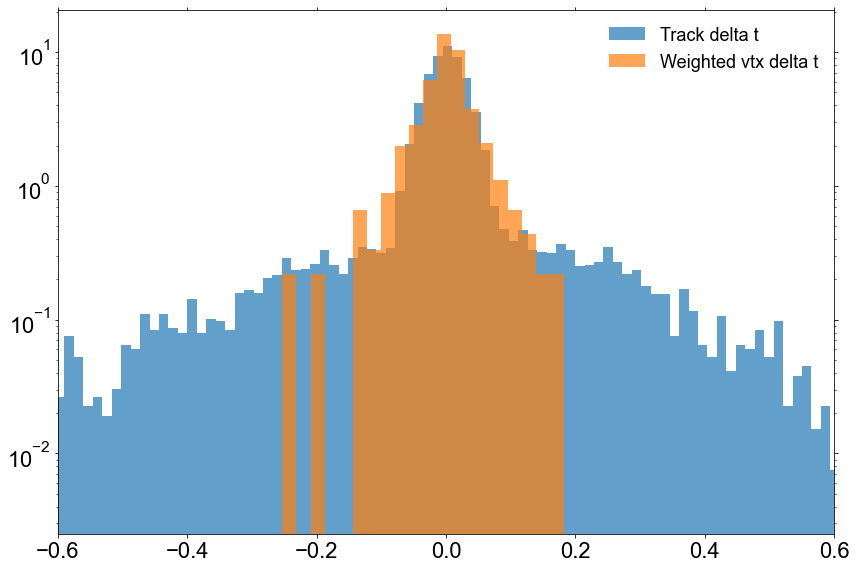

In [123]:
idx = 9
plt.hist(link_zLPU_vtx_t30_info['track_delta_t'][idx], bins=100, density=True, alpha=0.7, label='Track delta t')
# plt.hist(link_zLPU_vtx_t30_info['track_sigma_cut_delta_t'][idx], bins=100, density=True, alpha=0.7, label='Track delta t sigma cut')
# plt.hist(link_zLPU_vtx_t30_info['vtx_delta_t'][idx], bins=20, density=True, alpha=0.7, label='Unweighted vtx delta t')
plt.hist(link_zLPU_vtx_t30_info['vtx_weighted_delta_t'][idx], bins=20, density=True, alpha=0.7, label='Weighted vtx delta t')
# plt.hist(link_zLPU_vtx_t30_info['vtx_sigma_cut_weighted_delta_t'][idx], bins=20, density=True, alpha=0.7, label='Weighted vtx delta t vtx sigma cut')
plt.yscale('log')
plt.xlim(-0.6, 0.6)
plt.legend(frameon=False)
plt.tight_layout()
# print(np.std(np.concatenate(link_zLPU_vtx_z_info['track_sigma_cut_delta_z'][idx]), ddof=1)/30**0.5, np.std(link_zLPU_vtx_z_info['vtx_weighted_delta_z'][idx], ddof=1))

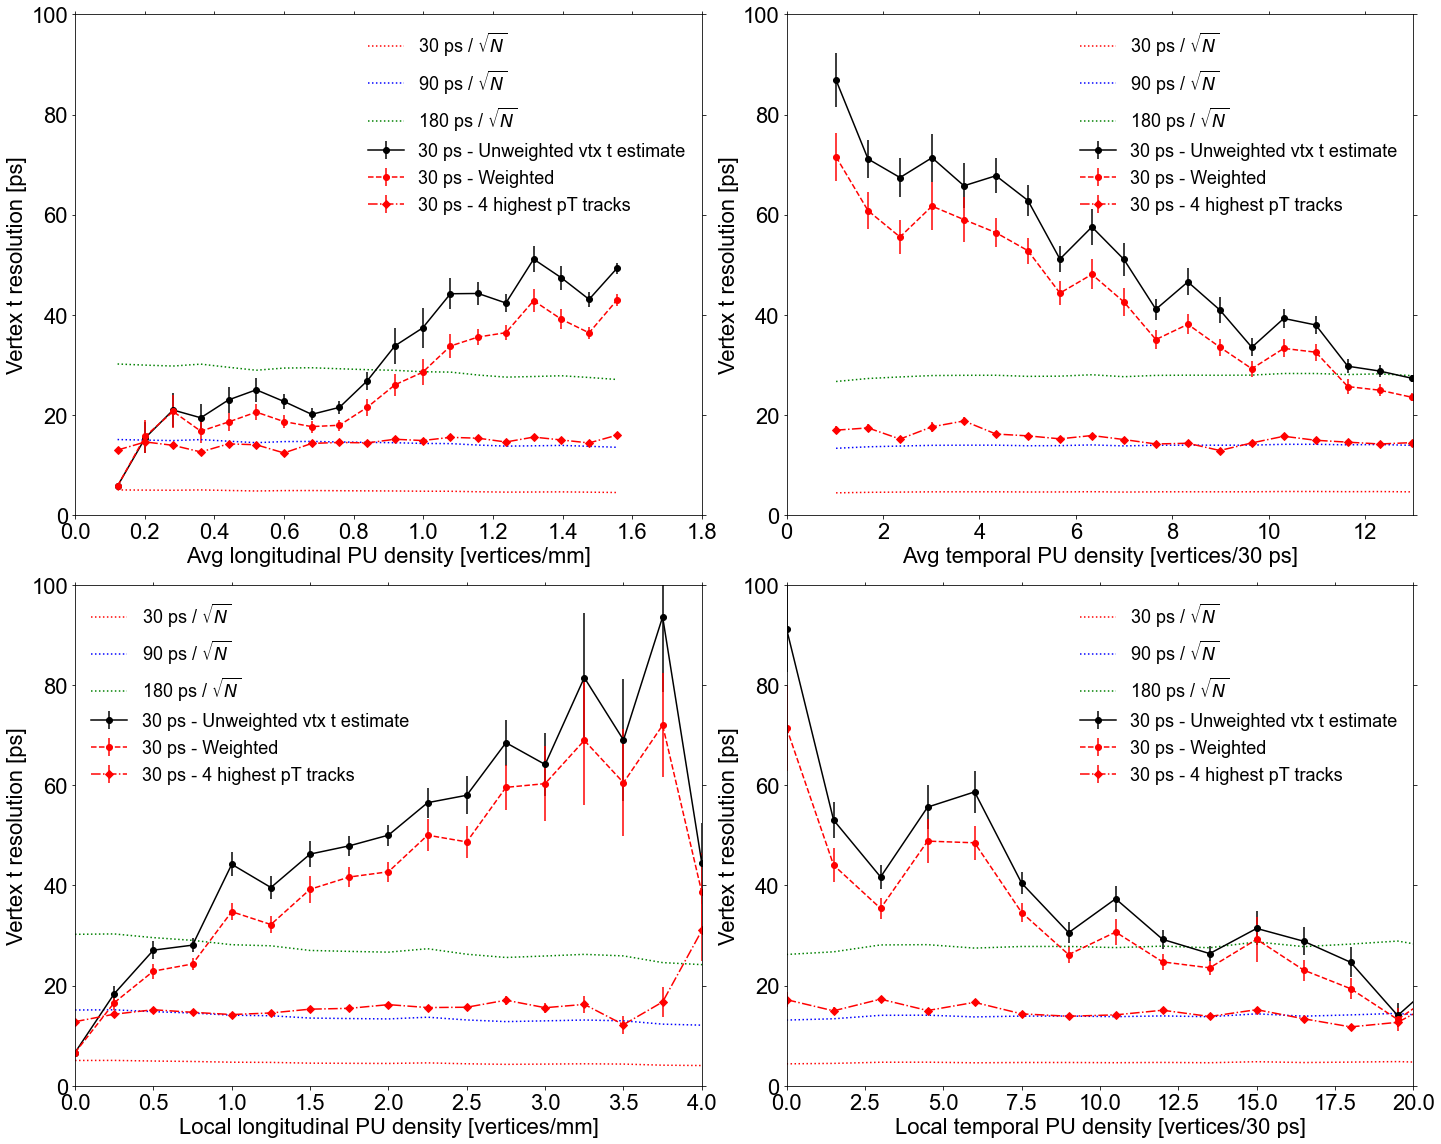

In [127]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info30 = (link_zAPU_vtx_t30_info, link_tAPU_vtx_t30_info, link_zLPU_vtx_t30_info, link_tLPU_vtx_t30_info)
all_link_vtx_info90 = (link_zAPU_vtx_t90_info, link_tAPU_vtx_t90_info, link_zLPU_vtx_t90_info, link_tLPU_vtx_t90_info)
all_link_vtx_info180 = (link_zAPU_vtx_t180_info, link_tAPU_vtx_t180_info, link_zLPU_vtx_t180_info, link_tLPU_vtx_t180_info)

for ax, bin_edges, link_vtx_info30, link_vtx_info90, link_vtx_info180 \
            in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info90, all_link_vtx_info180):
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_t_res']), \
                1e3*np.array(link_vtx_info30['vtx_t_res_std']), fmt='ko-', label='30 ps - Unweighted vtx t estimate')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['vtx_weighted_t_res']), \
    #             1e3*np.array(link_vtx_info90['vtx_weighted_t_res_std']), fmt='bo-', label='90 ps - Weighted vtx t estimate')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['vtx_weighted_t_res']), \
    #             1e3*np.array(link_vtx_info180['vtx_weighted_t_res_std']), fmt='go-', label='180 ps - Weighted vtx t estimate')

    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_weighted_t_res']),\
                    1e3*np.array(link_vtx_info30['vtx_weighted_t_res_std']), fmt='ro--', label='30 ps - Weighted')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['vtx_sigma_cut_weighted_t_res']),\
    #                 1e3*np.array(link_vtx_info90['vtx_sigma_cut_weighted_t_res_std']), fmt='bo--', label='90 ps - Weighted + sigma cut on vtx distribution')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['vtx_sigma_cut_weighted_t_res']),\
    #                 1e3*np.array(link_vtx_info180['vtx_sigma_cut_weighted_t_res_std']), fmt='go--', label='180 ps - Weighted + sigma cut on vtx distribution')


    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_weight_cut_t_res']),\
                    # 1e3*np.array(link_vtx_info30['vtx_weight_cut_t_res_std']), fmt='ro-', label='30 ps - weight cut on tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['vtx_weight_cut_t_res']),\
    #                 1e3*np.array(link_vtx_info90['vtx_weight_cut_t_res_std']), fmt='bo-', label='90 ps - weight cut on tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['vtx_weight_cut_t_res']),\
    #                 1e3*np.array(link_vtx_info180['vtx_weight_cut_t_res_std']), fmt='go-', label='180 ps - weight cut on tracks')

    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_4highest_pT_t_res_sigma_cut']),\
                    1e3*np.array(link_vtx_info30['vtx_4highest_pT_t_res_std_sigma_cut']), fmt='rD-.', label='30 ps - 4 highest pT tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['vtx_4highest_pT_t_res']),\
    #                 1e3*np.array(link_vtx_info90['vtx_4highest_pT_t_res_std']), fmt='bo-.', label='90 ps - 4 highest pT tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['vtx_4highest_pT_t_res']),\
    #                 1e3*np.array(link_vtx_info180['vtx_4highest_pT_t_res_std']), fmt='go-.', label='180 ps - 4 highest pT tracks')

    ax.plot(bin_edges, 30/np.sqrt(link_vtx_info30['avg_n_tracks']), 'r:', label='30 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 90/np.sqrt(link_vtx_info90['avg_n_tracks']), 'b:', label='90 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 180/np.sqrt(link_vtx_info180['avg_n_tracks']), 'g:', label='180 ps / $\\sqrt{N}$')

    # ax.hlines(12, 0, 100)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Vertex t resolution [ps]')
    ax.legend(frameon=False)

ax1.set_xlim(0, 1.8)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 13)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 4)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 20)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()

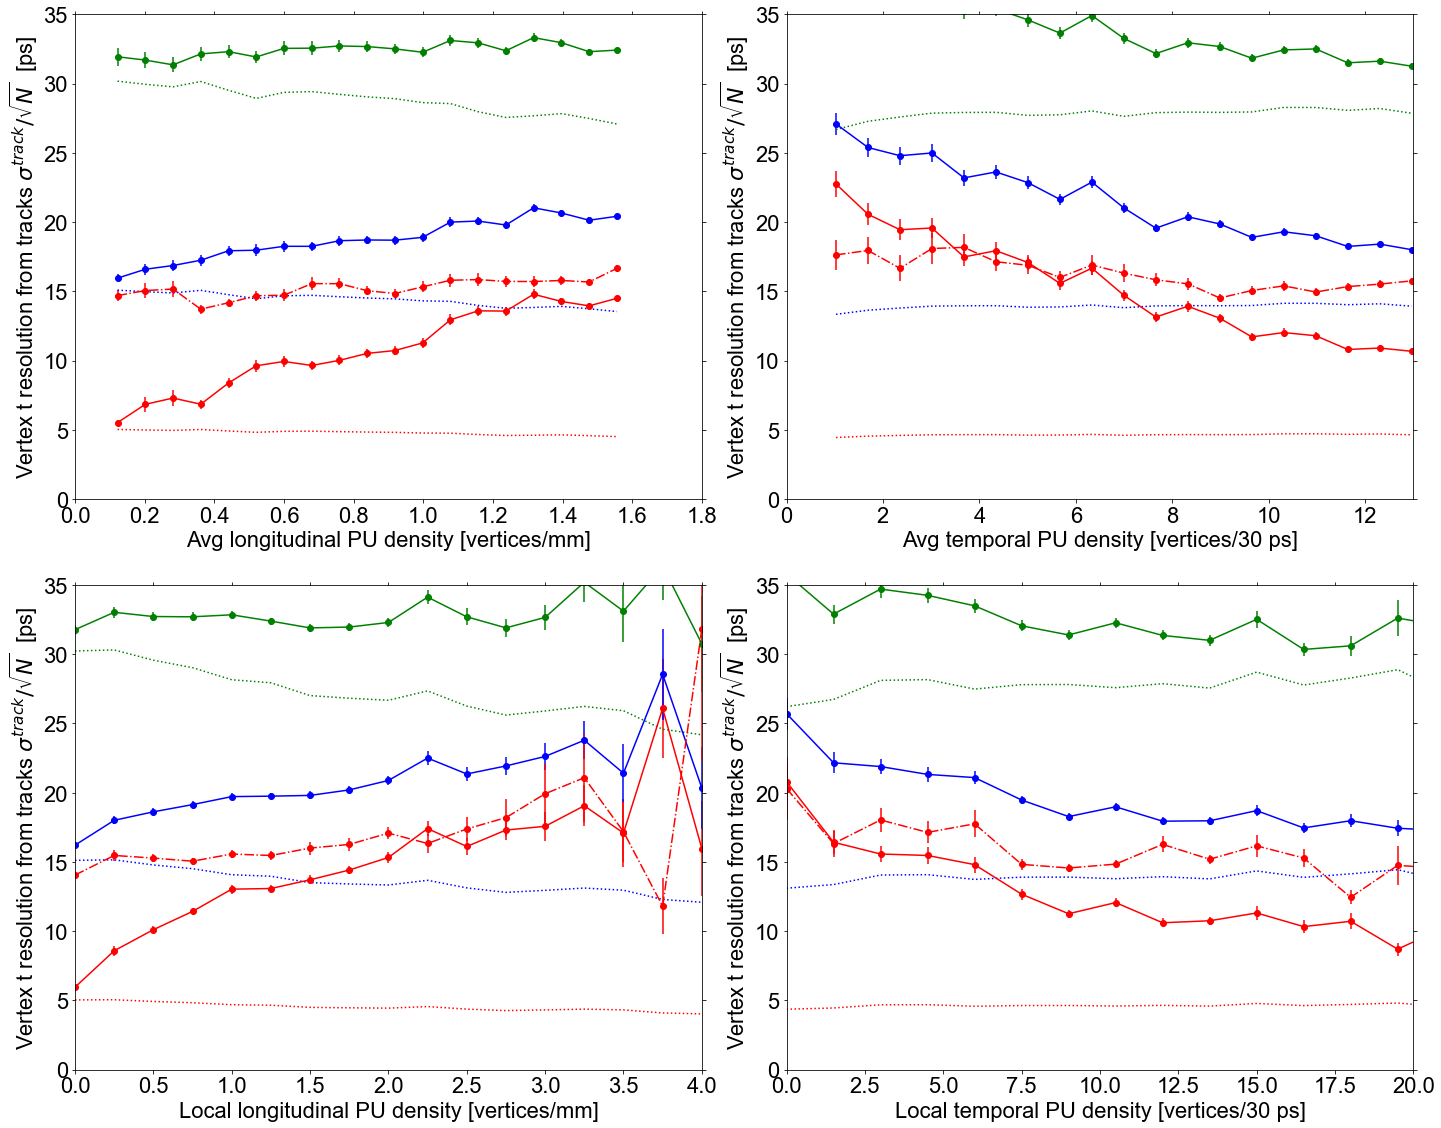

In [124]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info30 = (link_zAPU_vtx_t30_info, link_tAPU_vtx_t30_info, link_zLPU_vtx_t30_info, link_tLPU_vtx_t30_info)
all_link_vtx_info90 = (link_zAPU_vtx_t90_info, link_tAPU_vtx_t90_info, link_zLPU_vtx_t90_info, link_tLPU_vtx_t90_info)
all_link_vtx_info180 = (link_zAPU_vtx_t180_info, link_tAPU_vtx_t180_info, link_zLPU_vtx_t180_info, link_tLPU_vtx_t180_info)

for ax, bin_edges, link_vtx_info30, link_vtx_info90, link_vtx_info180 \
            in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info90, all_link_vtx_info180):
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_t_res']), \
                1e3*np.array(link_vtx_info30['track_vtx_t_res_std']), fmt='ro-', label='30 ps - Track vtx t estimate')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_t_res']), \
                1e3*np.array(link_vtx_info90['track_vtx_t_res_std']), fmt='bo-', label='90 ps - Track vtx t estimate')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_t_res']), \
                1e3*np.array(link_vtx_info180['track_vtx_t_res_std']), fmt='go-', label='180 ps - Track vtx t estimate')

    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_t_res_sigma_cut']),\
    #                 1e3*np.array(link_vtx_info30['track_vtx_t_res_std_sigma_cut']), fmt='ro--', label='30 ps - Sigma cut on track t distribution')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_t_res_sigma_cut']),\
    #                 1e3*np.array(link_vtx_info90['track_vtx_t_res_std_sigma_cut']), fmt='bo--', label='90 ps - Sigma cut on track t distribution')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_t_res_sigma_cut']),\
    #                 1e3*np.array(link_vtx_info180['track_vtx_t_res_std_sigma_cut']), fmt='go--', label='180 ps - Sigma cut on track t distribution')
    
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_4highest_pT_t_res']),\
                    1e3*np.array(link_vtx_info30['track_vtx_4highest_pT_t_res_std']), fmt='ro-.', label='30 ps - Sigma cut on track t distribution')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_4highest_pT_t_res']),\
                    1e3*np.array(link_vtx_info90['track_vtx_4highest_pT_t_res_std']), fmt='bo-.', label='90 ps - Sigma cut on track t distribution')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_4highest_pT_t_res']),\
                    1e3*np.array(link_vtx_info180['track_vtx_4highest_pT_t_res_std']), fmt='go-.', label='180 ps - Sigma cut on track t distribution')

    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_t_res_weight_cut']),\
    #                 1e3*np.array(link_vtx_info30['track_vtx_t_res_std_weight_cut']), fmt='ro-', label='30 ps - Weight cut on tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_t_res_weight_cut']),\
    #                 1e3*np.array(link_vtx_info90['track_vtx_t_res_std_weight_cut']), fmt='bo-', label='90 ps - Weight cut on tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_t_res_weight_cut']),\
    #                 1e3*np.array(link_vtx_info180['track_vtx_t_res_std_weight_cut']), fmt='go-', label='180 ps - Weight cut on tracks')


    ax.plot(bin_edges, 30/np.sqrt(link_vtx_info30['avg_n_tracks']), 'r:', label='30 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 90/np.sqrt(link_vtx_info90['avg_n_tracks']), 'b:', label='90 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 180/np.sqrt(link_vtx_info180['avg_n_tracks']), 'g:', label='180 ps / $\\sqrt{N}$')

    # ax.hlines(12, 0, 50)
    ax.set_ylim(0, 35)
    ax.set_ylabel('Vertex t resolution from tracks $\\sigma^{track}/\\sqrt{N}$  [ps]')
    # ax.legend(frameon=False)

ax1.set_xlim(0, 1.8)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 13)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 4)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 20)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()

Text(0, 0.5, 'Track pT')

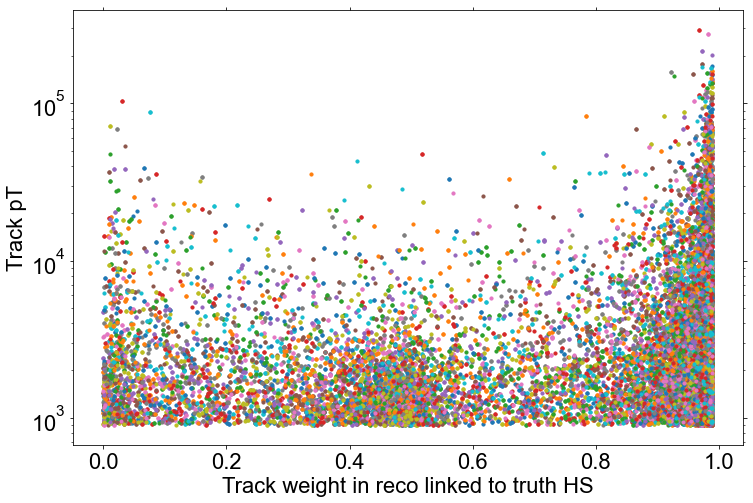

In [82]:
## Track pT vs track weight
for event_idx in range(0, 1000):
    reco_idx = truthHS_to_reco_link_idx[event_idx]
    event_track_pT = track_pT[event_idx][reco_vertex_track_idxs[event_idx][reco_idx]]
    event_track_weight = reco_vertex_track_weights[event_idx][reco_idx]
    plt.scatter(event_track_weight, event_track_pT, s=10)

plt.yscale('log')
plt.xlabel('Track weight in reco linked to truth HS')
plt.ylabel('Track pT')

In [ ]:
## pT vs weight
## vertex t estimation from 4 high pT tracks with/without weight > 0.9
## vertex t estimation from 4 highest weight

In [21]:
def old_vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut):
    track_delta_t = []
    track_delta_t_rms = []
    
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    
    track_vtx_t_res = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_sigma_cut = []
    
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_PU_bins, truth_vtx_idx_in_PU_bins, reco_vtx_idx_in_PU_bins):
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_t = reco_track_t[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
            
            weight_cut_event_delta_t = weight_cut_track_t - truth_t
        
            bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
            bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
            
            weight_cut_vtx_t = np.mean(weight_cut_track_t)
            weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
            bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))
        
    return  avg_n_tracks, \
            track_delta_t, \
            track_delta_t_rms, \
            track_weight_cut_delta_t, \
            track_weight_cut_delta_t_rms, \
            track_vtx_t_res, \
            track_vtx_t_res_weight_cut, \
            vtx_delta_t, \
            vtx_weight_cut_delta_t, \
            vtx_t_res, \
            vtx_weighted_t_res, \
            vtx_weight_cut_t_res, \
            vtx_weight_cut_weighted_t_res, \
            vtx_sigma_cut_weighted_t_res

def old_closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, sigma_cut, weight_cut):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return old_vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut)

def old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return old_vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut)
    

## TODO: write function to load root files into ram when needed instead of all at once 
    

        # bin_sigma = np.std(bin_closest_truth_delta_t)
        # bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
        # reco_n_tracks_events_cut = []
        # for idx in event_idxs:
        #     diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma]
        #     reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        #     bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
        # closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
        # avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

In [11]:
def closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, sigma_cut, weight_cut):
    track_delta_t = []
    track_delta_t_rms = []
    
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    
    track_vtx_t_res = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_sigma_cuts = []
    
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs in events_in_PU_bins:
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx in event_idxs:
            idx = idx[0]
            #Use reco HS - ie. largest sumpT2 vtx
            reco_vtx_z = all_reco_vtx_z[idx][0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][0]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            reco_track_weights = all_reco_track_weights[idx][0][reco_track_t_clean_idx]
            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][np.argmin(np.abs(all_truth_vtx_z[idx] - reco_vtx_z))]
            
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_t = reco_track_t[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
            
            weight_cut_event_delta_t = weight_cut_track_t - truth_t
        
            bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
            bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
            
            weight_cut_vtx_t = np.mean(weight_cut_track_t)
            weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
            bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))
        
    return  track_delta_t, \
            track_delta_t_rms, \
            track_weight_cut_delta_t, \
            track_weight_cut_delta_t_rms, \
            track_vtx_t_res, \
            track_vtx_t_res_weight_cut, \
            vtx_delta_t, \
            vtx_weight_cut_delta_t, \
            vtx_t_res, \
            vtx_weighted_t_res, \
            vtx_weight_cut_t_res, \
            vtx_weight_cut_weighted_t_res, \
            vtx_sigma_cut_weighted_t_res
            
        # bin_sigma = np.std(bin_closest_truth_delta_t)
        # bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
        # reco_n_tracks_events_cut = []
        # for idx in event_idxs:
        #     diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma]
        #     reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        #     bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
        # closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
        # avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

In [22]:
events_in_PU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))

link_avg_n_tracks30, \
link_track_delta_t30, \
link_track_delta_t30_rms, \
link_track_weight_cut_delta_t30, \
link_track_weight_cut_delta_t30_rms, \
link_track_vtx_t30_res, \
link_track_vtx_t30_res_weight_cut, \
link_vtx_delta_t30, \
link_vtx_weight_cut_delta_t30, \
link_vtx_t30_res, \
link_vtx_weighted_t30_res, \
link_vtx_weight_cut_t30_res, \
link_vtx_weight_cut_weighted_t30_res, \
link_vtx_sigma_cut_weighted_t30_res = old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t30, 2, 0.9)

link_avg_n_tracks90, \
link_track_delta_t90, \
link_track_delta_t90_rms, \
link_track_weight_cut_delta_t90, \
link_track_weight_cut_delta_t90_rms, \
link_track_vtx_t90_res, \
link_track_vtx_t90_res_weight_cut, \
link_vtx_delta_t90, \
link_vtx_weight_cut_delta_t90, \
link_vtx_t90_res, \
link_vtx_weighted_t90_res, \
link_vtx_weight_cut_t90_res, \
link_vtx_weight_cut_weighted_t90_res, \
link_vtx_sigma_cut_weighted_t90_res = old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t90, 2, 0.9)

link_avg_n_tracks180, \
link_track_delta_t180, \
link_track_delta_t180_rms, \
link_track_weight_cut_delta_t180, \
link_track_weight_cut_delta_t180_rms, \
link_track_vtx_t180_res, \
link_track_vtx_t180_res_weight_cut, \
link_vtx_delta_t180, \
link_vtx_weight_cut_delta_t180, \
link_vtx_t180_res, \
link_vtx_weighted_t180_res, \
link_vtx_weight_cut_t180_res, \
link_vtx_weight_cut_weighted_t180_res, \
link_vtx_sigma_cut_weighted_t180_res = old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t180, 2, 0.9)

In [60]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

avg_n_tracks, \
track_delta_t, \
track_delta_t_rms, \
track_weight_cut_delta_t, \
track_weight_cut_delta_t_rms, \
track_vtx_t_res, \
track_vtx_t_res_weight_cut, \
vtx_delta_t, \
vtx_weight_cut_delta_t, \
vtx_t_res, \
vtx_weighted_t_res, \
vtx_weight_cut_t_res, \
vtx_weight_cut_weighted_t_res,\
vtx_sigma_cut_weighted_t_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t, 2, 0.9)
avg_n_tracks30, \
track_delta_t30, \
track_delta_t30_rms, \
track_weight_cut_delta_t30, \
track_weight_cut_delta_t30_rms, \
track_vtx_t30_res, \
track_vtx_t30_res_weight_cut, \
vtx_delta_t30, \
vtx_weight_cut_delta_t30, \
vtx_t30_res, \
vtx_weighted_t30_res, \
vtx_weight_cut_t30_res, \
vtx_weight_cut_weighted_t30_res, \
vtx_sigma_cut_weighted_t30_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t30, 2, 0.9)

avg_n_tracks90, \
track_delta_t90, \
track_delta_t90_rms, \
track_weight_cut_delta_t90, \
track_weight_cut_delta_t90_rms, \
track_vtx_t90_res, \
track_vtx_t90_res_weight_cut, \
vtx_delta_t90, \
vtx_weight_cut_delta_t90, \
vtx_t90_res, \
vtx_weighted_t90_res, \
vtx_weight_cut_t90_res, \
vtx_weight_cut_weighted_t90_res, \
vtx_sigma_cut_weighted_t90_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t90, 2, 0.9)
                                                                
avg_n_tracks180, \
track_delta_t180, \
track_delta_t180_rms, \
track_weight_cut_delta_t180, \
track_weight_cut_delta_t180_rms, \
track_vtx_t180_res, \
track_vtx_t180_res_weight_cut, \
vtx_delta_t180, \
vtx_weight_cut_delta_t180, \
vtx_t180_res, \
vtx_weighted_t180_res, \
vtx_weight_cut_t180_res, \
vtx_weight_cut_weighted_t180_res, \
vtx_sigma_cut_weighted_t180_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t180, 2, 0.9)


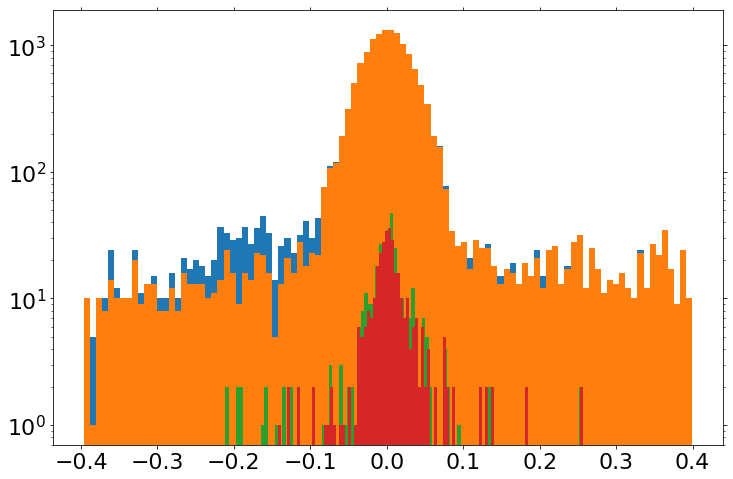

In [72]:
max_t = 0.4

plt.hist(np.concatenate(track_delta_t30)[np.abs(np.concatenate(track_delta_t30)) < max_t], bins = 100)
plt.hist(np.concatenate(link_track_delta_t30)[np.abs(np.concatenate(link_track_delta_t30)) < max_t], bins = 100)
plt.hist(np.concatenate(vtx_delta_t30)  [np.abs(np.concatenate(vtx_delta_t30)) < max_t]  , bins = 100)
plt.hist(np.concatenate(link_vtx_delta_t30)  [np.abs(np.concatenate(link_vtx_delta_t30)) < max_t]  , bins = 100)

plt.yscale('log')

In [40]:
bootstrapped_vtx_res = []
bootstrapped_vtx_res_std = []
for i in range(len(events_in_PU_bins)):
    bin_vtx_res = []
    for _ in range(1000):
        idx = np.random.randint(0, len(vtx_delta_t30[i]), len(vtx_delta_t30[i]))
        bin_vtx_res.append(np.sqrt(np.mean(np.array(vtx_delta_t30[i])[idx]**2)))
    bootstrapped_vtx_res.append(np.mean(bin_vtx_res))
    bootstrapped_vtx_res_std.append(np.std(bin_vtx_res))

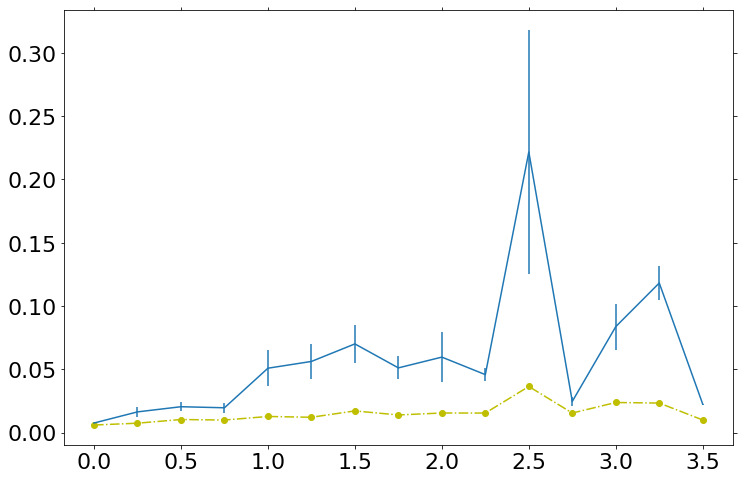

In [41]:
plt.errorbar(truth_bin_edges, bootstrapped_vtx_res, bootstrapped_vtx_res_std)
plt.plot(truth_bin_edges, np.array(track_vtx_t30_res), 'yo-.', label='Vtx resolution from tracks')


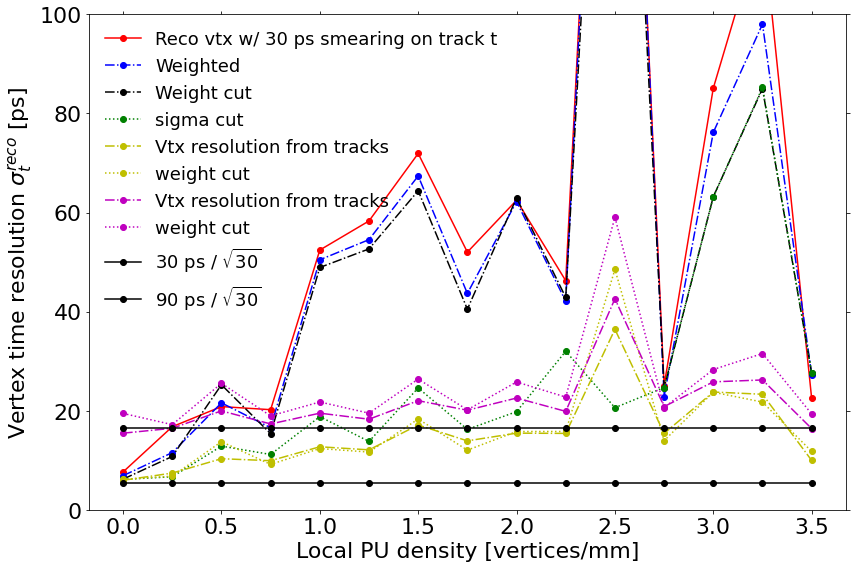

In [31]:
plt.plot(truth_bin_edges, 1e3*np.array(vtx_t30_res), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_weighted_t30_res), 'bo-.', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_weight_cut_t30_res), 'ko-.', label='Weight cut')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_sigma_cut_weighted_t30_res), 'go:', label='sigma cut')


plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res), 'yo-.', label='Vtx resolution from tracks')
plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res_weight_cut), 'yo:', label='weight cut')

plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res), 'mo-.', label='Vtx resolution from tracks')
plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res_weight_cut), 'mo:', label='weight cut')

plt.plot(truth_bin_edges, 30/np.sqrt(30*np.ones(len(truth_bin_edges))), 'ko-', label='30 ps / $\\sqrt{30}$')
plt.plot(truth_bin_edges, 90/np.sqrt(30*np.ones(len(truth_bin_edges))), 'ko-', label='90 ps / $\\sqrt{30}$')

plt.ylim(0, 100)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')
plt.tight_layout()

In [23]:
sigma_cut = 2

closest_truth_delta_t = []
closest_truth_delta_t_rms = []

closest_truth_vtx_t_res = []
closest_truth_vtx_weighted_t_res = []
closest_truth_vtx_weight_cut_t_res = []

closest_truth_vtx_t30_res = []
closest_truth_vtx_weighted_t30_res = []
closest_truth_vtx_weight_cut_t30_res = []

closest_truth_delta_t30 = []
closest_truth_delta_t30_rms = []
closest_truth_vtx_t30_res = []

closest_truth_vtx_t30_res_sigma_cut = []

events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

avg_n_tracks = []
avg_n_tracks30 = []
avg_n_tracks30_sigma_cut = []

for event_idxs in events_in_PU_bins:
    bin_closest_truth_delta_t = np.array([])
    bin_closest_truth_delta_t_rms = []
    
    bin_closest_truth_delta_t30 = np.array([])
    bin_closest_truth_delta_t30_rms = []
    
    bin_closest_truth_vtx_delta_t = []
    bin_closest_truth_vtx_delta_t30 = []
    bin_closest_truth_vtx_weighted_delta_t = []
    bin_closest_truth_vtx_weighted_delta_t30 = []
    
    bin_closest_truth_vtx_weight_cut_delta_t = []
    bin_closest_truth_vtx_weight_cut_delta_t30 = []
    
    reco_n_tracks_events = []
    reco_n_tracks_events30 = []
    
    for idx in event_idxs:
        idx = idx[0]
        # reco_track_weights = reco_vertex_track_weights[idx][0]
        
        reco_vtx_z = reco_vertex_z[idx][0]
        truth_t = truth_vertex_t[idx][np.argmin(np.abs(truth_vertex_z[idx] - reco_vtx_z))]
        
        #Use reco HS - ie. largest sumpT2 vtx
        reco_track_t = track_t[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
        reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
        
        reco_track_t30 = track_t30[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t30_clean_idx = np.logical_and(reco_track_t30 != -1e3, reco_track_t30 != -1e6)
        reco_track_t30 = reco_track_t30[reco_track_t30_clean_idx]
        
        diff_t = reco_track_t - truth_t
        diff_t30 = reco_track_t30 - truth_t
        
        reco_n_tracks_events.append(len(diff_t))
        reco_n_tracks_events30.append(len(diff_t30))
        
        bin_closest_truth_delta_t = np.concatenate((bin_closest_truth_delta_t, diff_t))
        bin_closest_truth_delta_t30 = np.concatenate((bin_closest_truth_delta_t30, diff_t30))
        
        bin_closest_truth_delta_t_rms.append(np.sqrt(np.mean(diff_t**2)))
        bin_closest_truth_delta_t30_rms.append(np.sqrt(np.mean(diff_t30**2)))
        
        
        reco_vtx_t = np.mean(reco_track_t)
        reco_vtx_t30 = np.mean(reco_track_t30)
        
        # reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights[reco_track_t_clean_idx])
        # reco_vtx_weighted_t30 = np.mean(reco_track_t30, weights=reco_track_weights[reco_track_t30_clean_idx])
        
        bin_closest_truth_vtx_delta_t.append(reco_vtx_t - truth_t)
        bin_closest_truth_vtx_delta_t30.append(reco_vtx_t30 - truth_t)
        # bin_closest_truth_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
        # bin_closest_truth_vtx_weighted_delta_t30.append(reco_vtx_weighted_t30 - truth_t)
        
    
    avg_n_tracks.append(np.mean(reco_n_tracks_events))
    avg_n_tracks30.append(np.mean(reco_n_tracks_events30))
    
    closest_truth_delta_t.append(bin_closest_truth_delta_t)
    closest_truth_delta_t30.append(bin_closest_truth_delta_t30)
    
    closest_truth_delta_t_rms.append(bin_closest_truth_delta_t_rms)
    closest_truth_delta_t30_rms.append(bin_closest_truth_delta_t30_rms)
    
    closest_truth_vtx_t_res.append(np.mean(bin_closest_truth_delta_t_rms / np.sqrt(np.array(reco_n_tracks_events))))
    closest_truth_vtx_t30_res.append(np.mean(bin_closest_truth_delta_t30_rms / np.sqrt((np.array(reco_n_tracks_events30)))))
    
    bin_sigma30 = np.std(bin_closest_truth_delta_t30)
    bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
    reco_n_tracks_events_cut = []
    for idx in event_idxs:
        diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma30]
        reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
    closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
    avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

Text(0.5, 0, 'Reco vtx track t - truth track t [ps]')

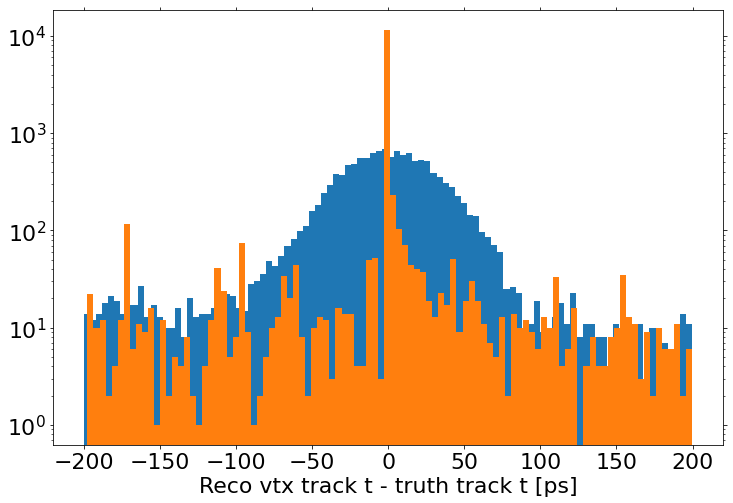

In [24]:
_ = plt.hist(1e3*np.concatenate(closest_truth_delta_t30)[np.abs(np.concatenate(closest_truth_delta_t30))<0.2], bins=100, label='No smearing')
_ = plt.hist(1e3*np.concatenate(closest_truth_delta_t)[np.abs(np.concatenate(closest_truth_delta_t))<0.2],     bins=100, label='30 ps smearing')
plt.yscale('log')
plt.xlabel('Reco vtx track t - truth track t [ps]')

Text(0, 0.5, 'Vertex time resolution $\\sigma^{reco}_t$ [ps]')

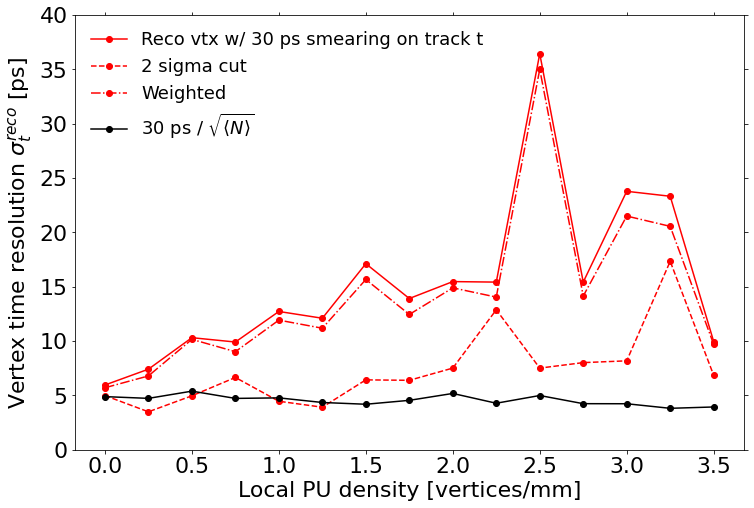

In [67]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_res), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_res_sigma_cut), 'ro--', label='{} sigma cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_weighted_res), 'ro-.', label='Weighted')
plt.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks), 'ko-', label='30 ps / $\\sqrt{\\langle N\\rangle}$')

plt.ylim(0, 40)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')

In [ ]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_avg_std_of_mean), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_std_of_mean_sigma_cut), 'ro--', label='{} sigma cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks), 'ko-', label='30 ps / $\\sqrt{\\langle N\\rangle}$')

plt.ylim(0, 30)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')